# Lesson 13 - NLP with Deep Learning

> An introduction to Deep Learning and its applications in NLP

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/dslectures/blob/master/notebooks/lesson13_nlp-deep.ipynb)[![slides](https://img.shields.io/static/v1?label=slides&message=lesson13_nlp-deep.pdf&color=blue&logo=Google-drive)](https://drive.google.com/open?id=1g613_b3643zUuPVB1JBBuyxXka_WRRWF)


> Note: Make sure you are connected to a GPU machine when running the Colab notebook by clicking on `Runtime -> Change runtime type` and set hardware type to GPU.

## Learning objectives
In this lecture we cover the basics of Deep Learning and its application to NLP. The learning goals are:
* The basics of transfer learning
* Preprocess data with the fastai data loader
* Train a text classifier with the fastai library

## References
* Practical Deep Learning for Coders - Lesson 4: Deep Learning 2019 by fastai [[video](https://www.youtube.com/watch?v=qqt3aMPB81c)]

This notebooks follows fastai's excellent tutotrial in this video and the original notebook can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb).

## Homework
As homework read the references, work carefully through the notebook and solve the exercises. 

## Introduction
Last time we built a sentiment classifier with `scikit-learn` and achieved around 85% accuracy on the test set. This is already pretty good, but can we do better? We are still wrong 15/100 times. It turns out we can if we use deep learning.

<div style="text-align: center">
<img src='images/deeper.jpg' width='400'>
</div>

Deep learning uses an architecture that is modeled after the brain and uses networks of artificial neurons to mimic its behaviour. These models are much bigger than the models we encountered so far and can have millions to billions of parameters. Training these models and adjusting the parameters is also more challenging, and generally requires much more data and compute. A lot of computations are easily parallelizable, which is a strength of modern GPUs. Therefore we will run this notebook on a GPU that enables much faster training than a CPU.

<div style="text-align: center">
<img src='images/gpu_meme.jpg' width='400'>
</div>

Since we don't have much training data on the IMDb dataset for deep learning standards we use transfer learning to still achieve high accuracy in predicting the sentiment of the movie reviews.

## Transfer learning
Training deep learning models requires a lot of data. It is not uncommon to train models on millions of images or gigabytes of text data to achieve good results. Most real-world problems don't have that amount of labeled data ready, and not all companies or individuals who want to train a model can afford to hire people to label data for them.

For many years this has been very challenging. Fortunately, it has been solved for image based models a couple of years ago and recently also for NLP. One approach that helps train models with limited labeled data is called **transfer learning**.

The idea is that once a model is trained on a large dataset for a specific task (e.g., classifying houses vs. planes), the model has learned certain features of the data that can be reused for another task. Such features could be how to detect edges or textures in images. If these features are useful for another task, then we can train the model on new data without requiring as many labels as if we were training it from scratch.

### ULMFiT
For transfer learning in NLP Jeremy Howard and Sebastian Ruder came up with a similar approach called `ULMFiT` (Universal Language Model Fine-tuning for Text Classification) for texts. The central theme of the approach is language modeling.

#### Language modeling
In language modeling the goal is to predict the next word based on the previous word in a text. An example:

`Yesterday I discovered a really nice cinema so I went there to watch a ____ .`

The task of the model is to fill the blank. The advantage of language modeling is that it does not require any labels, but to achieve good results, the model needs to learn a lot about language. In this example, the model needs to understand that one watches movies in cinemas. The same goes for sentiment and other topics. With `ULMFiT` one can train a language model and then use it for classifications tasks in three steps.

#### Three steps
The three steps are visualised in the following figure:
<div style="text-align: center">
<img src='images/ulmfit_approach.png' width='800'>
</div>

1. **Language model (wiki)**: A language model is trained on a large dataset. Wikipedia is a common choice for this task as it includes many topics, and the text is of high quality. This step usually takes the most time on the order of days. In this step, the model learns the general structure of language.

2. **Language model (domain)**: The language model trained on Wikipedia might be missing some aspects of the domain we are interested in. If we want to do sentiment classification, Wikipedia does not offer much insight since Wikipedia articles are generally of neutral sentiment. Therefore, we continue training the language model on the text we are interested in. This step still takes several hours.

3. **Classifier (domain)**: Now that the language model works well on the text we are interested in, it is time to build a classifier. We do this by adapting the output of the network to yield classes instead of words. This step only takes a couple of minutes to an hour to complete.

The power of this approach is that you only need little labeled data for the last step and only need to go through the expensive first step once. Even the second step can be reused on the dataset if you, for example, build a sentiment classifier and additionally a topic classifier. This can be done in minutes and allows us to achieve great results with little time and resources.

### Other methods
Today, there are many approaches in NLP that use transfer learning such as Google's BERT. These models cost on the order of $100'000 to pretrain (1. step) and massive computational facilities. Fortunately, most of these models are shared and can then be fine-tuned on small machines.

## The `fastai` library
The `fastai` library wraps around the deep learning framework `PyTorch` and has a lot of functionality built in to achieve great results quickly. The library abstracts a lot of functionality, so it can be difficult to follow initially. To get a better understanding, we highly recommend the [fastai course](https://course.fast.ai/). In this lesson, we will use the library to build a world-class classifier with just a few lines of code.

## Imports

In [ ]:
!pip install dslectures

In [ ]:
from fastai.text import *
from dslectures.core import get_dataset

## Training data

### Download data
The fastai library includes a lot of datasets including, the IMDb dataset we already know. Similar to our `download_dataset()` function we can do this with fastai's `untar_data()` function.

In [ ]:
path = untar_data(URLs.IMDB)

### Data structure
Looking at the downloaded folder, we can see that there are several files and folders. The relevant ones for our case are `test`, `train`, and `unsup`. The `train` and `test` folders split the data the same way we split it in the previous lecture. The new `unsup` (for unsupervised) folder contains 50k movie reviews that are not classified. We can't use them for training a classifier, but we can use them to fine-tune the language model.

In [ ]:
path.ls()

[PosixPath('/storage/data/imdb/README'),
 PosixPath('/storage/data/imdb/tmp_lm'),
 PosixPath('/storage/data/imdb/imdb.vocab'),
 PosixPath('/storage/data/imdb/tmp_clas'),
 PosixPath('/storage/data/imdb/test'),
 PosixPath('/storage/data/imdb/train'),
 PosixPath('/storage/data/imdb/unsup')]

Looking at the training folder, we find two folders for the negative and positive movie reviews.

In [ ]:
(path/'train/').ls()

In both folders, we find many files, each containing one movie review. This is exactly the same data we used last time. It is just arranged in a different structure. We don't need to load all these files manually - the fastai library does this automatically. 

In [ ]:
(path/'train/neg').ls()[:10]

[PosixPath('/storage/data/imdb/train/neg/573_1.txt'),
 PosixPath('/storage/data/imdb/train/neg/4084_1.txt'),
 PosixPath('/storage/data/imdb/train/neg/10475_1.txt'),
 PosixPath('/storage/data/imdb/train/neg/1830_1.txt'),
 PosixPath('/storage/data/imdb/train/neg/3070_2.txt'),
 PosixPath('/storage/data/imdb/train/neg/9556_4.txt'),
 PosixPath('/storage/data/imdb/train/neg/6659_1.txt'),
 PosixPath('/storage/data/imdb/train/neg/6035_1.txt'),
 PosixPath('/storage/data/imdb/train/neg/6056_2.txt'),
 PosixPath('/storage/data/imdb/train/neg/1579_1.txt')]

## Fine-tune language model

> Note: Fine-tuning the language model takes around 4h. You can skip this step and download the fine-tuned model in the *Load language model* section of the notebook.

### Preprocess data for language modeling
In the last lecture, we implemented our own function to preprocess the texts and tokenize them. In principle, we could do the same here, but fastai comes with built-in functions to take care of this. In addtion, we can specify which folders to use and what percentage to split off for validation. The batch size `bs` specifies how many samples the model is optimised for at each step. 

In [ ]:
bs=48

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

Similar to the vectorizer vocabulary, we can have a look at the encoding scheme. The `itos` (stands for id-to-string) object tells us which token is encoded at which position.

In [ ]:
len(data_lm.vocab.itos)

We can see that the vocabulary contains XXX tokens.

In [ ]:
data_lm.vocab.itos[:20]


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

We can see that the first few positions are reserved for special tokens starting with `xx`. The token `xxunk` is used for a word that is not in the dictionary. The `xxbos` and `xxeos` identify the beginning and the end of a string. So if the first entry in the encoding vector is 1 this means that the token is `xxunk`. If the third entry is 1 then the token is `xxbos`.

We can also look at a processed text. We notice that the token `xxmaj` is used frequently. It signifies that the first letter of the following word is capitalised.

In [ ]:
data_lm.train_ds[0][0]

Text xxbos xxmaj while the design and locations and photography are strong assets in this film ; it is a turgid and melodramatic affair which demonstrates the limits of cinema to convey truth . 
 
  xxmaj the case is the use of the soundtrack music : a mix of xxmaj gustav xxmaj mahler and xxmaj andrew xxmaj lloyd - xxmaj webber that plays constantly and loudly , and would have made xxmaj max xxmaj steiner grimace at its over use as it instructs the audience how difficult ; how ecstatic ; how tortured it is to be an artist . xxmaj and then it really counts the story xxunk the details at the end . 
 
  xxmaj this heightened and kitsch exploitation of emotions was once well ridiculed by xxmaj peter xxmaj ackroyd about a xxmaj yukio xxmaj mishima book : xxmaj this is not writing , this is xxmaj barbara xxmaj cartland . xxmaj precisely the same critique can be made of this film : a deceptive , mawkish vanity project .

With fastai we can also sample a batch from the dataset and display the sample in a dataframe:

In [ ]:
data_lm.show_batch()

idx,text
0,xxmaj max xxmaj steiner grimace at its over use as it instructs the audience how difficult ; how ecstatic ; how tortured it is to be an artist . xxmaj and then it really counts the story xxunk the details at the end . \n \n xxmaj this heightened and kitsch exploitation of emotions was once well ridiculed by xxmaj peter xxmaj ackroyd about a xxmaj yukio xxmaj mishima
1,"call it horror . xxmaj there is too much talking , you will get bloodthirsty after watching it xxbos i 'd liked the xxmaj takashi xxmaj miike films i 'd seen so far , but i found this pretty disappointing . i 'd bought it , but i wo n't be keeping it . \n \n i saw it on the xxmaj xxunk xxup dvd , which has just"
2,"xxmaj gable 's laughable playing of an xxmaj irish patriot in xxmaj parnell . \n \n xxmaj it 's inconceivable that xxmaj bergman would choose both this movie and its director over a lucrative xxmaj hollywood career where she could choose among the finest scripts and directors being offered at that time . xxmaj to begin with , there was no script to work with except a few notes"
3,"worst of the lot ! xxmaj it does not have the feel of \n \n the original or 2nd , xxmaj the enemy 's look stupid and the levels are \n \n even worse . xxmaj it does not look realistic anymore ! i did not enjoy his game unlike the last two , the first had great \n \n background music and the 2nd was not"
4,"ever made , ever . xxmaj unfortunately my worst fears were confirmed & one has to say that xxmaj curse of the xxmaj wolf is a truly horrible film in every way , both conceptually & technically . xxmaj curse of the xxmaj wolf is the sort of film where the low budget dictates what happens & the script rather than the script dictating the budget . xxmaj you get"


### Representation
When we vectorized the texts in the last lecture, we represented them as count vectors. The architecture we use in this lecture allows for each word to be processed sequentially and thus conserving the order information. Therefore we encode the text with **one-hot encodings**. However, storing the information as vectors would not be very memory efficient; one entry is 1 and all the other entries are 0. It is more efficient to just store the information on which entry is 1 and then create the vector when we need it.

We can look at the data representation of the example we printed above. Each number represents a word in the vocabulary and specifies the entry in the one-hot encoding that is set to one.

In [ ]:
data_lm.train_ds[0][0].data[:10]

array([   2,    5,  154,    9, 1682,   12, 1854,   12, 1352,   39])

With the `itos` we can translate it back to tokens:

In [ ]:
for i in data_lm.train_ds[0][0].data[:10]:
    print(data_lm.vocab.itos[i])

### Train model
We will train a variant of a model called LSTM (long short-term memory) network. This is a neural network with a feedback loop. That means that when fed a sequence of tokens, it feeds back its output for the next prediction. With this the model has a mechanism remembering the past inputs. This is especially useful when dealing with sequential data such as texts, where the sequence of words and characters carries important meaning.

<div style="text-align: center">
<img src='images/rnn-diagram.png' width='400'>
    <p style="text-align: center;"> <b>Reference:</b> https://colah.github.io/posts/2015-08-Understanding-LSTMs/ </p>
</div>

#### Load pretrained model
Training the model on Wikipedia takes a day or two. Fortunately, people have already trained the model and shared it in the fastai library. Therefore, we can just load the pretrained langauge model. When we load it, we also pass the dataset it will be trained on.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, model_dir="../data/")

#### Learning rate finder
The learning rate is a key parameter when training models in deep learning. It specifies how strongly we update the model parameters. If the learning rate is too small, the training takes forever. If the learning rate is too big, we will never converge to a minimum.

With the `lr_find()` function, we can explore how the loss function behaves with regards to the value of the learning rate:

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


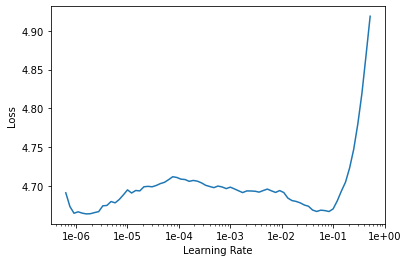

In [ ]:
learn.recorder.plot(skip_end=15)

First of all, we see that if we choose the learning rate too big, the loss function starts to increase. We want to avoid this at all costs. So we want to find the spot where the loss function decreases the steepest with the largest learning rate. In this case, a good value is `1e-2`. The first parameter determines how many epochs we train. One epoch corresponds to one pass through the training set.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.145812,4.027751,0.294872,24:40


Deep learning models learn more and more abstractions with each layer. The first layers of an image model might learn about edges and textures in an image, and as you progress through the layers, you can see how the model combines edges to eyes or ears and eventually combines these to faces. Therefore the last few layers are usually the ones that are very task-specific while the others contain general information.

For this reason, we usually start by just tuning the last few layers because we don't want to lose that information and then, in the end, fine-tune the whole model. This is what we did above: we just trained the last few layers. Now to get the best possible performance, we want to train the whole model. The `unfreeze()` function enables the training of the whole model. We train the model for 10 more epochs with a slightly lower learning rate.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.883628,3.846353,0.312791,25:13
1,3.830023,3.806326,0.319647,25:14
2,3.823724,3.776663,0.323472,25:14
3,3.790490,3.747104,0.327012,25:14
4,3.708543,3.720774,0.330030,25:14
5,3.685525,3.700337,0.332860,25:14
6,3.594311,3.683683,0.334876,25:14
7,3.559871,3.672719,0.336452,25:14
8,3.545992,3.668409,0.337152,25:14
9,3.494757,3.668425,0.337193,25:14


### Save language model
Since the step above took about 4h we want to save the progress, so we don't have to repeat the step when we restart the notebook.

In [ ]:
# uncomment if you want to fine-tune the language mode
# data_lm.path = Path('')
# data_lm.save('data_lm.pkl')
# learn.save('fine_tuned')

### Load language model

In [ ]:
get_dataset("fine_tuned.pth")
get_dataset("data_lm.pkl")

In [ ]:
data_lm = load_data(Path("../data/"), 'data_lm.pkl', bs=bs)
data_lm.path = path

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, model_dir="../data/")
learn.path = Path("")
learn.load('fine_tuned');
learn.path = path

### Text generation
The objective of a language model is to predict the next word based on a sequence of words. We can use the trained model to generate some movie reviews:

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it had a nice twist , i liked it . i like all of the characters in the movie , the same in each one . Displayed refreshing to see . The story and acting were really good
I liked this movie because it was about a person playing far , the same way . It had some good moments of humor , but it really did n't make an epic film . i really did n't understand why the audience was


### Exercise 1
Generate a few movie reviews with different input texts. Post the funniest review on the Teams channel.

### Encoder
As mentioned previously, the last layers of a deep learning model are usually the most task-specific. In the case of language modeling, the last layer predicts the next word in a sequence. We want to do text classification, however, so we don't need that layer. Therefore, we discard the last layer and only save what is called the encoder. In the next step, we add a new layer on top of the encoder for text classification.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Train classifier
In this section, we will use the fine-tuned language model and build a text classifier on top of it.  The procedure is very similar to the language model fine-tuning but needs some minor adjustments for text classification.

### Preprocess data for classification
Preprocessing the data follows similar steps as for language modeling. The main differences are that 1) we don't want a random train/valid split, but the official one and 2) we want to label each element with its sentiment based on the folder name.

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

When we display a batch we see that the tokens look the same with the addition of a label column:

In [ ]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj by now you 've probably heard a bit about the new xxmaj disney dub of xxmaj miyazaki 's classic film , xxmaj laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky . xxmaj during late summer of 1998 , xxmaj disney released "" xxmaj kiki 's xxmaj delivery xxmaj service "" on video which included a preview of the xxmaj laputa dub saying it was due out",pos
"xxbos xxmaj some have praised xxunk xxmaj lost xxmaj xxunk as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of",neg
"xxbos xxmaj by 1987 xxmaj hong xxmaj kong had given the world such films as xxmaj sammo xxmaj hung 's ` xxmaj encounters of the xxmaj spooky xxmaj kind ' xxmaj chow xxmaj yun xxmaj fat in xxmaj john xxmaj woo 's iconic ` a xxmaj better xxmaj tomorrow ' , ` xxmaj zu xxmaj warriors ' and the classic ` xxmaj mr xxmaj vampire ' . xxmaj jackie xxmaj",pos
"xxbos xxmaj to be a xxmaj buster xxmaj keaton fan is to have your heart broken on a regular basis . xxmaj most of us first encounter xxmaj keaton in one of the brilliant feature films from his great period of independent production : ' xxmaj the xxmaj general ' , ' xxmaj the xxmaj navigator ' , ' xxmaj sherlock xxmaj jnr ' . xxmaj we recognise him as",neg


### Load model
We create a text classifier model and load the pretrained encoder part from the fine-tuned language model into it.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, model_dir="../data/")
learn.load_encoder('fine_tuned_enc');

### Find the learning rate
Again, we need to find the best learning rate for training the classifier.

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


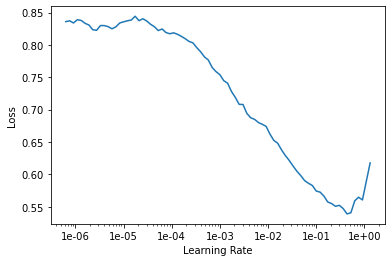

In [ ]:
learn.recorder.plot()

### Train classifier
We start by just training the very last layer:

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.325401,0.261644,0.892640,04:50


Then we unfreeze the second to last layer as well and train these layers.

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.267379,0.217356,0.913600,05:13


Next, we train the last three layers.

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.233473,0.182271,0.930040,04:54


Finally, we train all layers for two epochs.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.201170,0.175181,0.933120,05:09
1,0.182616,0.174323,0.932920,05:07


Note that after the last optimisation step the model can predict the sentiment on the test set with **94%** accuracy. This is roughly 10% better than our Naïve Bayes model from the last lecture. In other words, this model makes **3 times** fewer mistakes than the Naïve Bayes model!

### Make predictions

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([3.5403e-06, 1.0000e+00]))

### Exercise 2
Experiment with the trained classifier and see if you can fool it. Can you find a pattern that fools it consistently?